70:30

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

data = pd.read_csv('C:/Users/Marco Luminarias/Downloads/Building Energy Efficiency.csv')

imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

data_imputed['Volume'] = data_imputed['Surface Area'] * data_imputed['Overall Height']
data_imputed['Wall/Roof Ratio'] = data_imputed['Wall Area'] / data_imputed['Roof Area']

data_final = data_imputed

X = data_final.drop(['Heating Load', 'Cooling Load'], axis=1)
Y1 = data_final['Heating Load']
Y2 = data_final['Cooling Load']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X_scaled, Y1, Y2, test_size=0.3, random_state=52)


rf_model_heating = RandomForestRegressor(random_state=20, n_estimators=500, max_depth=70, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
rf_model_heating.fit(X_train, Y1_train)

rf_model_cooling = RandomForestRegressor(random_state=20, n_estimators=500, max_depth=70, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
rf_model_cooling.fit(X_train, Y2_train)

# Define the validation set
eval_set = [(X_test, Y1_test)]
# Define early stopping criteria
early_stopping = 20 # Number of rounds with no improvement on the validation set

xgb_model_heating = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, random_state=20, n_estimators=2000, max_depth=70, learning_rate=0.05, min_child_weight=2, gamma=0, colsample_bytree=0.6)
xgb_model_heating.fit(X_train, Y1_train, early_stopping_rounds=early_stopping, eval_set=eval_set, verbose=True)

xgb_model_cooling = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, random_state=20, n_estimators=2000, max_depth=70, learning_rate=0.05, min_child_weight=2, gamma=0, colsample_bytree=0.6)
xgb_model_cooling.fit(X_train, Y2_train, early_stopping_rounds=early_stopping, eval_set=eval_set, verbose=True)

heating_models = [('Random Forest', rf_model_heating), ('XGBoost', xgb_model_heating)]
heating_ensemble = VotingRegressor(heating_models)
heating_ensemble.fit(X_train, Y1_train)

cooling_models = [('Random Forest', rf_model_cooling), ('XGBoost', xgb_model_cooling)]
cooling_ensemble = VotingRegressor(cooling_models)
cooling_ensemble.fit(X_train, Y2_train)

Y1_pred_train_ensemble = heating_ensemble.predict(X_train)
Y1_pred_test_ensemble = heating_ensemble.predict(X_test)

Y2_pred_train_ensemble = cooling_ensemble.predict(X_train)
Y2_pred_test_ensemble = cooling_ensemble.predict(X_test)

# Evaluation metrics for Heating Load
r2_train_ensemble_heating = r2_score(Y1_train, Y1_pred_train_ensemble)
r2_test_ensemble_heating = r2_score(Y1_test, Y1_pred_test_ensemble)
mse_train_ensemble_heating = mean_squared_error(Y1_train, Y1_pred_train_ensemble)
mse_test_ensemble_heating = mean_squared_error(Y1_test, Y1_pred_test_ensemble)
rmse_train_ensemble_heating = np.sqrt(mse_train_ensemble_heating)
rmse_test_ensemble_heating = np.sqrt(mse_test_ensemble_heating)

# Evaluation metrics for Cooling Load
r2_train_ensemble_cooling = r2_score(Y2_train, Y2_pred_train_ensemble)
r2_test_ensemble_cooling = r2_score(Y2_test, Y2_pred_test_ensemble)
mse_train_ensemble_cooling = mean_squared_error(Y2_train, Y2_pred_train_ensemble)
mse_test_ensemble_cooling = mean_squared_error(Y2_test, Y2_pred_test_ensemble)
rmse_train_ensemble_cooling = np.sqrt(mse_train_ensemble_cooling)
rmse_test_ensemble_cooling = np.sqrt(mse_test_ensemble_cooling)

# ! Combining training and testing Metrics

# ? R-Squared for TRAINING
weight_heating = 2
weight_cooling = 1
harmonic_r2_mean_training = (r2_train_ensemble_heating * weight_heating + r2_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
# harmonic_r2_mean_training = 2 / ((1 / r2_train_ensemble_heating) + (1 / r2_train_ensemble_cooling))
# ? R-Squared for TESTING
weight_heating = 2
weight_cooling = 1
harmonic_r2_mean_testing = (r2_test_ensemble_heating * weight_heating + r2_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
# harmonic_r2_mean_testing = 2 / ((1 / r2_test_ensemble_heating) + (1 / r2_test_ensemble_cooling))

# ? MSE for TRAINING
weight_heating = 2
weight_cooling = 1
weighted_average_mse_training = (mse_train_ensemble_heating * weight_heating + mse_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)

# ? MSE for Testing
weight_heating = 2
weight_cooling = 1
weighted_average_mse_testing = (mse_test_ensemble_heating * weight_heating + mse_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)

# ? RMSE for Testing
weight_heating = 2
weight_cooling = 1
weighted_average_rmse_training = (rmse_train_ensemble_heating * weight_heating + rmse_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)

# ? RMSE for Testing
weight_heating = 2
weight_cooling = 1
weighted_average_rmse_testing = (rmse_test_ensemble_heating * weight_heating + rmse_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
# Plotting actual vs. predicted values for Heating Load
# plt.figure(figsize=(10, 5))
# plt.plot(Y1_test, label='Actual Heating Load', color='blue')
# plt.plot(Y1_pred_test_ensemble, label='Predicted Heating Load', color='orange')
# plt.xlabel('Sample Index')
# plt.ylabel('Heating Load')
# plt.title('Actual vs. Predicted Heating Load')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting actual vs. predicted values for Cooling Load
# plt.figure(figsize=(10, 5))
# plt.plot(Y2_test, label='Actual Cooling Load', color='red')
# plt.plot(Y2_pred_test_ensemble, label='Predicted Cooling Load', color='green')
# plt.xlabel('Sample Index')
# plt.ylabel('Cooling Load')
# plt.title('Actual vs. Predicted Cooling Load')
# plt.legend()
# plt.grid(True)
# plt.show()
print("Combined R2 (Training): ", harmonic_r2_mean_training)
print("Combined R2 (Testing): ", harmonic_r2_mean_testing)
print("\nCombined MSE (Training): ", weighted_average_mse_training)
print("Combined MSE (Testing): ", weighted_average_mse_testing)
print("\nCombined RMSE (Training): ", weighted_average_rmse_training)
print("Combined RMSE (Testing): ", weighted_average_rmse_testing)

# Print results for Heating Load
print("\nResults for Heating Load (Ensemble - Random Forest and XGBoost):")
print("R-squared (Training):", r2_train_ensemble_heating)
print("R-squared (Testing):", r2_test_ensemble_heating)
print("MSE (Training):", mse_train_ensemble_heating)
print("MSE (Testing):", mse_test_ensemble_heating)
print("RMSE (Training):", rmse_train_ensemble_heating)
print("RMSE (Testing):", rmse_test_ensemble_heating)

# Print results for Cooling Load
print("\nResults for Cooling Load (Ensemble - Random Forest and XGBoost):")
print("R-squared (Training):", r2_train_ensemble_cooling)
print("R-squared (Testing):", r2_test_ensemble_cooling)
print("MSE (Training):", mse_train_ensemble_cooling)
print("MSE (Testing):", mse_test_ensemble_cooling)
print("RMSE (Training):", rmse_train_ensemble_cooling)
print("RMSE (Testing):", rmse_test_ensemble_cooling)


[0]	validation_0-rmse:9.36999
[1]	validation_0-rmse:8.92521
[2]	validation_0-rmse:8.50902
[3]	validation_0-rmse:8.12456
[4]	validation_0-rmse:7.74538
[5]	validation_0-rmse:7.39255
[6]	validation_0-rmse:7.04158
[7]	validation_0-rmse:6.70469
[8]	validation_0-rmse:6.40585
[9]	validation_0-rmse:6.11369
[10]	validation_0-rmse:5.83143
[11]	validation_0-rmse:5.55958
[12]	validation_0-rmse:5.30177
[13]	validation_0-rmse:5.05922
[14]	validation_0-rmse:4.82525
[15]	validation_0-rmse:4.60236
[16]	validation_0-rmse:4.39509
[17]	validation_0-rmse:4.19159
[18]	validation_0-rmse:4.00058
[19]	validation_0-rmse:3.81866
[20]	validation_0-rmse:3.64446
[21]	validation_0-rmse:3.48208
[22]	validation_0-rmse:3.32329
[23]	validation_0-rmse:3.17327
[24]	validation_0-rmse:3.03523
[25]	validation_0-rmse:2.90299
[26]	validation_0-rmse:2.77286
[27]	validation_0-rmse:2.64731
[28]	validation_0-rmse:2.52971
[29]	validation_0-rmse:2.41758
[30]	validation_0-rmse:2.31124
[31]	validation_0-rmse:2.21563
[32]	validation_0-

c:\laragon\bin\python\python-3.10\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:0.77578
[61]	validation_0-rmse:0.75385
[62]	validation_0-rmse:0.74115
[63]	validation_0-rmse:0.72039
[64]	validation_0-rmse:0.70200
[65]	validation_0-rmse:0.68912
[66]	validation_0-rmse:0.67841
[67]	validation_0-rmse:0.66198
[68]	validation_0-rmse:0.64499
[69]	validation_0-rmse:0.63522
[70]	validation_0-rmse:0.62674
[71]	validation_0-rmse:0.61406
[72]	validation_0-rmse:0.60527
[73]	validation_0-rmse:0.59372
[74]	validation_0-rmse:0.58547
[75]	validation_0-rmse:0.57362
[76]	validation_0-rmse:0.56711
[77]	validation_0-rmse:0.56111
[78]	validation_0-rmse:0.55247
[79]	validation_0-rmse:0.54813
[80]	validation_0-rmse:0.54313
[81]	validation_0-rmse:0.53955
[82]	validation_0-rmse:0.53562
[83]	validation_0-rmse:0.53224
[84]	validation_0-rmse:0.52237
[85]	validation_0-rmse:0.52032
[86]	validation_0-rmse:0.51190
[87]	validation_0-rmse:0.50944
[88]	validation_0-rmse:0.50799
[89]	validation_0-rmse:0.50055
[90]	validation_0-rmse:0.49214
[91]	validation_0-rmse:0.48544
[92]	val

80:20

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

data = pd.read_csv('C:/Users/Marco Luminarias/One Drive/OneDrive/Documents/dataset_1K.csv')
# data = pd.read_csv('C:/Users/Marco Luminarias/Downloads/Building Energy Efficiency.csv')

imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

data_imputed['Volume'] = data_imputed['Surface Area'] * data_imputed['Overall Height']
data_imputed['Wall/Roof Ratio'] = data_imputed['Wall Area'] / data_imputed['Roof Area']

data_final = data_imputed

X = data_final.drop(['Heating Load', 'Cooling Load'], axis=1)
Y1 = data_final['Heating Load']
Y2 = data_final['Cooling Load']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X_scaled, Y1, Y2, test_size=0.2, random_state=20)

rf_model_heating = RandomForestRegressor(random_state=20, n_estimators=500, max_depth=70, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
rf_model_heating.fit(X_train, Y1_train)

rf_model_cooling = RandomForestRegressor(random_state=20, n_estimators=500, max_depth=70, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
rf_model_cooling.fit(X_train, Y2_train)

# Define the validation set
eval_set = [(X_test, Y1_test)]
# Define early stopping criteria
early_stopping = 20 # Number of rounds with no improvement on the validation set

xgb_model_heating = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, random_state=20, n_estimators=2000, max_depth=70, learning_rate=0.05, min_child_weight=2, gamma=0, colsample_bytree=0.6)
xgb_model_heating.fit(X_train, Y1_train, early_stopping_rounds=early_stopping, eval_set=eval_set, verbose=True)

xgb_model_cooling = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, random_state=20, n_estimators=2000, max_depth=70, learning_rate=0.05, min_child_weight=2, gamma=0, colsample_bytree=0.6)
xgb_model_cooling.fit(X_train, Y2_train, early_stopping_rounds=early_stopping, eval_set=eval_set, verbose=True)

heating_models = [('Random Forest', rf_model_heating), ('XGBoost', xgb_model_heating)]
heating_ensemble = VotingRegressor(heating_models)
heating_ensemble.fit(X_train, Y1_train)

cooling_models = [('Random Forest', rf_model_cooling), ('XGBoost', xgb_model_cooling)]
cooling_ensemble = VotingRegressor(cooling_models)
cooling_ensemble.fit(X_train, Y2_train)

Y1_pred_train_ensemble = heating_ensemble.predict(X_train)
Y1_pred_test_ensemble = heating_ensemble.predict(X_test)

Y2_pred_train_ensemble = cooling_ensemble.predict(X_train)
Y2_pred_test_ensemble = cooling_ensemble.predict(X_test)

# Evaluation metrics for Heating Load
r2_train_ensemble_heating = r2_score(Y1_train, Y1_pred_train_ensemble)
r2_test_ensemble_heating = r2_score(Y1_test, Y1_pred_test_ensemble)
mse_train_ensemble_heating = mean_squared_error(Y1_train, Y1_pred_train_ensemble)
mse_test_ensemble_heating = mean_squared_error(Y1_test, Y1_pred_test_ensemble)
rmse_train_ensemble_heating = np.sqrt(mse_train_ensemble_heating)
rmse_test_ensemble_heating = np.sqrt(mse_test_ensemble_heating)

# Evaluation metrics for Cooling Load
r2_train_ensemble_cooling = r2_score(Y2_train, Y2_pred_train_ensemble)
r2_test_ensemble_cooling = r2_score(Y2_test, Y2_pred_test_ensemble)
mse_train_ensemble_cooling = mean_squared_error(Y2_train, Y2_pred_train_ensemble)
mse_test_ensemble_cooling = mean_squared_error(Y2_test, Y2_pred_test_ensemble)
rmse_train_ensemble_cooling = np.sqrt(mse_train_ensemble_cooling)
rmse_test_ensemble_cooling = np.sqrt(mse_test_ensemble_cooling)

# ! Combining training and testing Metrics

# ? R-Squared for TRAINING
weight_heating = 2
weight_cooling = 1
harmonic_r2_mean_training = (r2_train_ensemble_heating * weight_heating + r2_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
# harmonic_r2_mean_training = 2 / ((1 / r2_train_ensemble_heating) + (1 / r2_train_ensemble_cooling))
# ? R-Squared for TESTING
weight_heating = 2
weight_cooling = 1
harmonic_r2_mean_testing = (r2_test_ensemble_heating * weight_heating + r2_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
# harmonic_r2_mean_testing = 2 / ((1 / r2_test_ensemble_heating) + (1 / r2_test_ensemble_cooling))

# ? MSE for TRAINING
weight_heating = 2
weight_cooling = 1
weighted_average_mse_training = (mse_train_ensemble_heating * weight_heating + mse_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)

# ? MSE for Testing
weight_heating = 2
weight_cooling = 1
weighted_average_mse_testing = (mse_test_ensemble_heating * weight_heating + mse_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)

# ? RMSE for Testing
weight_heating = 2
weight_cooling = 1
weighted_average_rmse_training = (rmse_train_ensemble_heating * weight_heating + rmse_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)

# ? RMSE for Testing
weight_heating = 2
weight_cooling = 1
weighted_average_rmse_testing = (rmse_test_ensemble_heating * weight_heating + rmse_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
# Plotting actual vs. predicted values for Heating Load
# plt.figure(figsize=(10, 5))
# plt.plot(Y1_test, label='Actual Heating Load', color='blue')
# plt.plot(Y1_pred_test_ensemble, label='Predicted Heating Load', color='orange')
# plt.xlabel('Sample Index')
# plt.ylabel('Heating Load')
# plt.title('Actual vs. Predicted Heating Load')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plotting actual vs. predicted values for Cooling Load
# plt.figure(figsize=(10, 5))
# plt.plot(Y2_test, label='Actual Cooling Load', color='red')
# plt.plot(Y2_pred_test_ensemble, label='Predicted Cooling Load', color='green')
# plt.xlabel('Sample Index')
# plt.ylabel('Cooling Load')
# plt.title('Actual vs. Predicted Cooling Load')
# plt.legend()
# plt.grid(True)
# plt.show()
print("Combined R2 (Training): ", harmonic_r2_mean_training)
print("Combined R2 (Testing): ", harmonic_r2_mean_testing)
print("\nCombined MSE (Training): ", weighted_average_mse_training)
print("Combined MSE (Testing): ", weighted_average_mse_testing)
print("\nCombined RMSE (Training): ", weighted_average_rmse_training)
print("Combined RMSE (Testing): ", weighted_average_rmse_testing)

# Print results for Heating Load
print("\nResults for Heating Load (Ensemble - Random Forest and XGBoost):")
print("R-squared (Training):", r2_train_ensemble_heating)
print("R-squared (Testing):", r2_test_ensemble_heating)
print("MSE (Training):", mse_train_ensemble_heating)
print("MSE (Testing):", mse_test_ensemble_heating)
print("RMSE (Training):", rmse_train_ensemble_heating)
print("RMSE (Testing):", rmse_test_ensemble_heating)

# Print results for Cooling Load
print("\nResults for Cooling Load (Ensemble - Random Forest and XGBoost):")
print("R-squared (Training):", r2_train_ensemble_cooling)
print("R-squared (Testing):", r2_test_ensemble_cooling)
print("MSE (Training):", mse_train_ensemble_cooling)
print("MSE (Testing):", mse_test_ensemble_cooling)
print("RMSE (Training):", rmse_train_ensemble_cooling)
print("RMSE (Testing):", rmse_test_ensemble_cooling)


[0]	validation_0-rmse:10.46522
[1]	validation_0-rmse:10.12566


c:\laragon\bin\python\python-3.10\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:9.79905
[3]	validation_0-rmse:9.47319
[4]	validation_0-rmse:9.17243
[5]	validation_0-rmse:8.86470
[6]	validation_0-rmse:8.59881
[7]	validation_0-rmse:8.35158
[8]	validation_0-rmse:8.12675
[9]	validation_0-rmse:7.91771
[10]	validation_0-rmse:7.70589
[11]	validation_0-rmse:7.52112
[12]	validation_0-rmse:7.35179
[13]	validation_0-rmse:7.18605
[14]	validation_0-rmse:7.04650
[15]	validation_0-rmse:6.91497
[16]	validation_0-rmse:6.79787
[17]	validation_0-rmse:6.68508
[18]	validation_0-rmse:6.56856
[19]	validation_0-rmse:6.46987
[20]	validation_0-rmse:6.37276
[21]	validation_0-rmse:6.28290
[22]	validation_0-rmse:6.20013
[23]	validation_0-rmse:6.13095
[24]	validation_0-rmse:6.06474
[25]	validation_0-rmse:6.01478
[26]	validation_0-rmse:5.96082
[27]	validation_0-rmse:5.91017
[28]	validation_0-rmse:5.87426
[29]	validation_0-rmse:5.82775
[30]	validation_0-rmse:5.79524
[31]	validation_0-rmse:5.75198
[32]	validation_0-rmse:5.72211
[33]	validation_0-rmse:5.69446
[34]	validation_

GRIDSEARCH EXPERIMENT

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Load the data
data = pd.read_csv('C:/Users/Marco Luminarias/Downloads/Building Energy Efficiency.csv')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Feature engineering
data_imputed['Volume'] = data_imputed['Surface Area'] * data_imputed['Overall Height']
data_imputed['Wall/Roof Ratio'] = data_imputed['Wall Area'] / data_imputed['Roof Area']

# Prepare data
X = data_imputed.drop(['Heating Load', 'Cooling Load'], axis=1)
Y1 = data_imputed['Heating Load']
Y2 = data_imputed['Cooling Load']
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split(X_scaled, Y1, Y2, test_size=0.2, random_state=20)

# Define parameter grids for Random Forest and XGBoost
rf_param_grid = {
    'n_estimators': [500, 750, 1000, 1250, 1500, 1750, 2000],
    'max_depth': [70, 80, 90, 100, None],
    'min_samples_split': [2, 3, 5, 7, 10, 15],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'bootstrap': [True, False],
    'max_features': [None, 'sqrt', 'log2']
}

xgb_param_grid = {
    'n_estimators': [500, 750, 1000, 1250, 1500, 1750, 2000],
    'max_depth': [70, 80, 90, 100],
    'min_child_weight': [1, 2, 3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1]
}

# Perform grid search for Random Forest
rf_grid_search = RandomizedSearchCV(RandomForestRegressor(random_state=20),
                                param_distributions=rf_param_grid,
                                n_iter=300,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                verbose=2,
                                n_jobs=-1
                             )
rf_grid_search.fit(X_train, Y1_train)
best_rf_params = rf_grid_search.best_params_

# Perform grid search for XGBoost
xgb_grid_search = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=20),
                                param_distributions=xgb_param_grid,
                                n_iter=1500,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                verbose=2,
                                n_jobs=-1
                              )
xgb_grid_search.fit(X_train, Y1_train)
best_xgb_params = xgb_grid_search.best_params_

# Update models with the best parameters
rf_model_heating = RandomForestRegressor(random_state=20, **best_rf_params)
rf_model_heating.fit(X_train, Y1_train)

xgb_model_heating = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=20, **best_xgb_params)
xgb_model_heating.fit(X_train, Y1_train)

# Define the validation set
eval_set = [(X_test, Y1_test)]
# Define early stopping criteria
early_stopping = 200

# Train XGBoost with early stopping
xgb_model_cooling = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=20, **best_xgb_params)
xgb_model_cooling.fit(X_train, Y2_train, early_stopping_rounds=early_stopping, eval_set=eval_set, verbose=True)

# Train Random Forest for cooling load
rf_model_cooling = RandomForestRegressor(random_state=20, **best_rf_params)
rf_model_cooling.fit(X_train, Y2_train)

# Create voting ensembles
heating_models = [('Random Forest', rf_model_heating), ('XGBoost', xgb_model_heating)]
cooling_models = [('Random Forest', rf_model_cooling), ('XGBoost', xgb_model_cooling)]
heating_ensemble = VotingRegressor(heating_models)
cooling_ensemble = VotingRegressor(cooling_models)

# Fit the ensembles
heating_ensemble.fit(X_train, Y1_train)
cooling_ensemble.fit(X_train, Y2_train)

# Predictions
Y1_pred_train_ensemble = heating_ensemble.predict(X_train)
Y1_pred_test_ensemble = heating_ensemble.predict(X_test)
Y2_pred_train_ensemble = cooling_ensemble.predict(X_train)
Y2_pred_test_ensemble = cooling_ensemble.predict(X_test)

# Evaluation metrics for Heating Load
r2_train_ensemble_heating = r2_score(Y1_train, Y1_pred_train_ensemble)
r2_test_ensemble_heating = r2_score(Y1_test, Y1_pred_test_ensemble)
mse_train_ensemble_heating = mean_squared_error(Y1_train, Y1_pred_train_ensemble)
mse_test_ensemble_heating = mean_squared_error(Y1_test, Y1_pred_test_ensemble)
rmse_train_ensemble_heating = np.sqrt(mse_train_ensemble_heating)
rmse_test_ensemble_heating = np.sqrt(mse_test_ensemble_heating)

# Evaluation metrics for Cooling Load
r2_train_ensemble_cooling = r2_score(Y2_train, Y2_pred_train_ensemble)
r2_test_ensemble_cooling = r2_score(Y2_test, Y2_pred_test_ensemble)
mse_train_ensemble_cooling = mean_squared_error(Y2_train, Y2_pred_train_ensemble)
mse_test_ensemble_cooling = mean_squared_error(Y2_test, Y2_pred_test_ensemble)
rmse_train_ensemble_cooling = np.sqrt(mse_train_ensemble_cooling)
rmse_test_ensemble_cooling = np.sqrt(mse_test_ensemble_cooling)

# Calculate combined metrics
weight_heating = 2
weight_cooling = 1
harmonic_r2_mean_training = (r2_train_ensemble_heating * weight_heating + r2_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
harmonic_r2_mean_testing = (r2_test_ensemble_heating * weight_heating + r2_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
weighted_average_mse_training = (mse_train_ensemble_heating * weight_heating + mse_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
weighted_average_mse_testing = (mse_test_ensemble_heating * weight_heating + mse_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
weighted_average_rmse_training = (rmse_train_ensemble_heating * weight_heating + rmse_train_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)
weighted_average_rmse_testing = (rmse_test_ensemble_heating * weight_heating + rmse_test_ensemble_cooling * weight_cooling) / (weight_cooling + weight_heating)


print("Best Random Forest parameters:", rf_grid_search.best_params_)
print("Best XGBoost parameters:", xgb_grid_search.best_params_)


# Print the results
print("Combined R2 (Training): ", harmonic_r2_mean_training)
print("Combined R2 (Testing): ", harmonic_r2_mean_testing)
print("\nCombined MSE (Training): ", weighted_average_mse_training)
print("Combined MSE (Testing): ", weighted_average_mse_testing)
print("\nCombined RMSE (Training): ", weighted_average_rmse_training)
print("Combined RMSE (Testing): ", weighted_average_rmse_testing)

# Print results for Heating Load
print("\nResults for Heating Load (Ensemble - Random Forest and XGBoost):")
print("R-squared (Training):", r2_train_ensemble_heating)
print("R-squared (Testing):", r2_test_ensemble_heating)
print("MSE (Training):", mse_train_ensemble_heating)
print("MSE (Testing):", mse_test_ensemble_heating)
print("RMSE (Training):", rmse_train_ensemble_heating)
print("RMSE (Testing):", rmse_test_ensemble_heating)

# Print results for Cooling Load
print("\nResults for Cooling Load (Ensemble - Random Forest and XGBoost):")
print("R-squared (Training):", r2_train_ensemble_cooling)
print("R-squared (Testing):", r2_test_ensemble_cooling)
print("MSE (Training):", mse_train_ensemble_cooling)
print("MSE (Testing):", mse_test_ensemble_cooling)
print("RMSE (Training):", rmse_train_ensemble_cooling)
print("RMSE (Testing):", rmse_test_ensemble_cooling)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
[0]	validation_0-rmse:8.79508
[1]	validation_0-rmse:7.48296
[2]	validation_0-rmse:6.53843
[3]	validation_0-rmse:5.82496
[4]	validation_0-rmse:5.23708
[5]	validation_0-rmse:4.80452
[6]	validation_0-rmse:4.37097
[7]	validation_0-rmse:4.04065
[8]	validation_0-rmse:3.88104
[9]	validation_0-rmse:3.72897
[10]	validation_0-rmse:3.60861
[11]	validation_0-rmse:3.45331
[12]	validation_0-rmse:3.34178
[13]	validation_0-rmse:3.31392
[14]	validation_0-rmse:3.21924
[15]	validation_0-rmse:3.15504
[16]	validation_0-rmse:3.12723
[17]	validation_0-rmse:3.06293
[18]	validation_0-rmse:3.01866
[19]	validation_0-rmse:2.99534
[20]	validation_0-rmse:2.97012
[21]	validation_0-rmse:2.98357
[22]	validation_0-rmse:2.96584
[23]	validation_0-rmse:2.95081
[24]	validation_0-rmse:2.96638
[25]	validation_0-rmse:2.96221
[26]	validation_0-rmse:2.95741
[27]	validation_0-rmse:2.94836
[28]	validati

c:\laragon\bin\python\python-3.10\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:2.97455
[33]	validation_0-rmse:2.97567
[34]	validation_0-rmse:2.97476
[35]	validation_0-rmse:2.97526
[36]	validation_0-rmse:2.97289
[37]	validation_0-rmse:2.97775
[38]	validation_0-rmse:2.99040
[39]	validation_0-rmse:2.99163
[40]	validation_0-rmse:2.98298
[41]	validation_0-rmse:2.98208
[42]	validation_0-rmse:2.99096
[43]	validation_0-rmse:2.99827
[44]	validation_0-rmse:3.00210
[45]	validation_0-rmse:2.99995
[46]	validation_0-rmse:3.00077
[47]	validation_0-rmse:3.00124
[48]	validation_0-rmse:3.00425
[49]	validation_0-rmse:3.00458
[50]	validation_0-rmse:3.00621
[51]	validation_0-rmse:3.01438
[52]	validation_0-rmse:3.01627
[53]	validation_0-rmse:3.01736
[54]	validation_0-rmse:3.01819
[55]	validation_0-rmse:3.02155
[56]	validation_0-rmse:3.01849
[57]	validation_0-rmse:3.02021
[58]	validation_0-rmse:3.01797
[59]	validation_0-rmse:3.02160
[60]	validation_0-rmse:3.02441
[61]	validation_0-rmse:3.02676
[62]	validation_0-rmse:3.02769
[63]	validation_0-rmse:3.03088
[64]	val

VALIDATION SET

[0]	validation_0-rmse:9.11149
[1]	validation_0-rmse:8.68414
[2]	validation_0-rmse:8.28952
[3]	validation_0-rmse:7.92054
[4]	validation_0-rmse:7.55434
[5]	validation_0-rmse:7.22185
[6]	validation_0-rmse:6.88020
[7]	validation_0-rmse:6.55867
[8]	validation_0-rmse:6.27127
[9]	validation_0-rmse:5.98802
[10]	validation_0-rmse:5.72143


c:\laragon\bin\python\python-3.10\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-rmse:5.45904
[12]	validation_0-rmse:5.20491
[13]	validation_0-rmse:4.98151
[14]	validation_0-rmse:4.75310
[15]	validation_0-rmse:4.53444
[16]	validation_0-rmse:4.33795
[17]	validation_0-rmse:4.13783
[18]	validation_0-rmse:3.95035
[19]	validation_0-rmse:3.77096
[20]	validation_0-rmse:3.59843
[21]	validation_0-rmse:3.44984
[22]	validation_0-rmse:3.29632
[23]	validation_0-rmse:3.15026
[24]	validation_0-rmse:3.02154
[25]	validation_0-rmse:2.90090
[26]	validation_0-rmse:2.77539
[27]	validation_0-rmse:2.65599
[28]	validation_0-rmse:2.54308
[29]	validation_0-rmse:2.43735
[30]	validation_0-rmse:2.33710
[31]	validation_0-rmse:2.24727
[32]	validation_0-rmse:2.15502
[33]	validation_0-rmse:2.07761
[34]	validation_0-rmse:2.00775
[35]	validation_0-rmse:1.92770
[36]	validation_0-rmse:1.85242
[37]	validation_0-rmse:1.78402
[38]	validation_0-rmse:1.72619
[39]	validation_0-rmse:1.67825
[40]	validation_0-rmse:1.61788
[41]	validation_0-rmse:1.57349
[42]	validation_0-rmse:1.52986
[43]	val

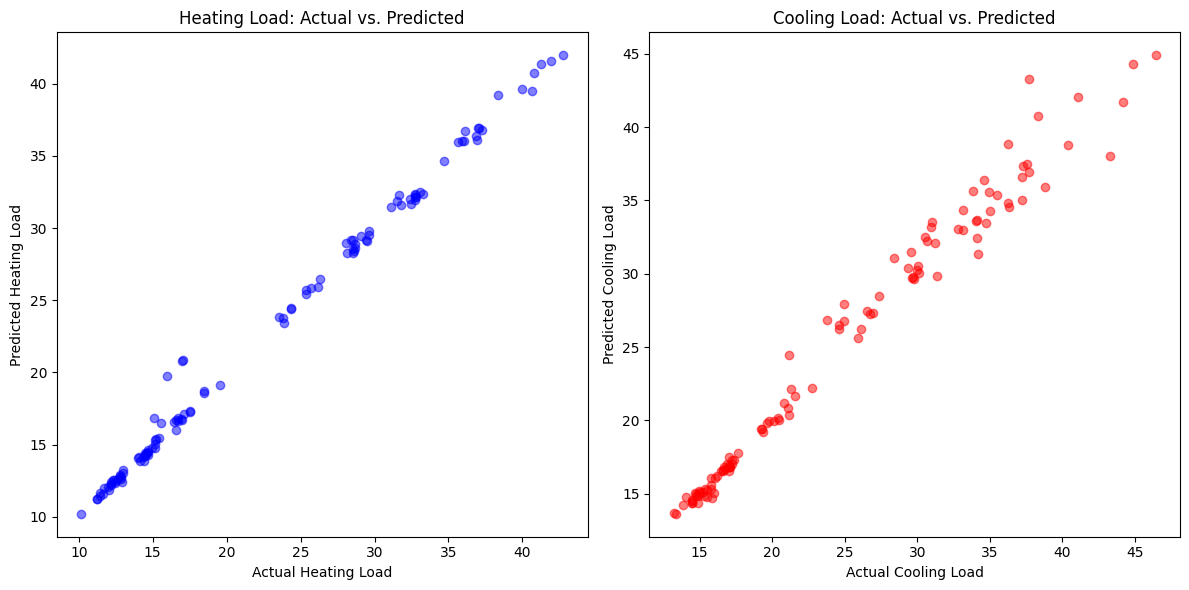

In [7]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Read data
data = pd.read_csv('C:/Users/Marco Luminarias/Downloads/Building Energy Efficiency.csv')

# Start timer
hybrid_start_time = time.time()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Feature engineering
data_imputed['Volume'] = data_imputed['Surface Area'] * data_imputed['Overall Height']
data_imputed['Wall/Roof Ratio'] = data_imputed['Wall Area'] / data_imputed['Roof Area']

data_final = data_imputed

# Define features and targets
X = data_final.drop(['Heating Load', 'Cooling Load'], axis=1)
Y1 = data_final['Heating Load']
Y2 = data_final['Cooling Load']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and testing sets
X_train, X_temp, Y1_train, Y1_temp, Y2_train, Y2_temp = train_test_split(X_scaled, Y1, Y2, test_size=0.3, random_state=40)
X_val, X_test, Y1_val, Y1_test, Y2_val, Y2_test = train_test_split(X_temp, Y1_temp, Y2_temp, test_size=0.5, random_state=40)

# Train Random Forest models
rf_model_heating = RandomForestRegressor(random_state=20, n_estimators=500, max_depth=70, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
rf_model_heating.fit(X_train, Y1_train)

rf_model_cooling = RandomForestRegressor(random_state=20, n_estimators=500, max_depth=70, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', bootstrap=False)
rf_model_cooling.fit(X_train, Y2_train)

# Train XGBoost models
xgb_model_heating = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, random_state=20, n_estimators=2000, max_depth=70, learning_rate=0.05, min_child_weight=2, gamma=0, colsample_bytree=0.6)
xgb_model_heating.fit(X_train, Y1_train, eval_set=[(X_val, Y1_val)], early_stopping_rounds=50, verbose=True)

xgb_model_cooling = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', subsample=0.8, random_state=20, n_estimators=2000, max_depth=70, learning_rate=0.05, min_child_weight=2, gamma=0, colsample_bytree=0.6)
xgb_model_cooling.fit(X_train, Y2_train, eval_set=[(X_val, Y2_val)], early_stopping_rounds=50, verbose=True)

# Create ensembles
heating_models = [('Random Forest', rf_model_heating), ('XGBoost', xgb_model_heating)]
heating_ensemble = VotingRegressor(heating_models)
heating_ensemble.fit(X_train, Y1_train)

cooling_models = [('Random Forest', rf_model_cooling), ('XGBoost', xgb_model_cooling)]
cooling_ensemble = VotingRegressor(cooling_models)
cooling_ensemble.fit(X_train, Y2_train)

# Make predictions
Y1_pred_val_ensemble = heating_ensemble.predict(X_val)
Y2_pred_val_ensemble = cooling_ensemble.predict(X_val)

# Calculate metrics for the validation set
r2_val_ensemble_heating = r2_score(Y1_val, Y1_pred_val_ensemble)
mse_val_ensemble_heating = mean_squared_error(Y1_val, Y1_pred_val_ensemble)
rmse_val_ensemble_heating = np.sqrt(mse_val_ensemble_heating)

r2_val_ensemble_cooling = r2_score(Y2_val, Y2_pred_val_ensemble)
mse_val_ensemble_cooling = mean_squared_error(Y2_val, Y2_pred_val_ensemble)
rmse_val_ensemble_cooling = np.sqrt(mse_val_ensemble_cooling)

# Print results for the validation set
print("\nResults for Heating Load (Validation set):")
print(f"R-squared: {r2_val_ensemble_heating:.4f}")
print(f"MSE: {mse_val_ensemble_heating:.4f}")
print(f"RMSE: {rmse_val_ensemble_heating:.4f}")

print("\nResults for Cooling Load (Validation set):")
print(f"R-squared: {r2_val_ensemble_cooling:.4f}")
print(f"MSE: {mse_val_ensemble_cooling:.4f}")
print(f"RMSE: {rmse_val_ensemble_cooling:.4f}")

# Optionally, you can visualize the actual vs. predicted values for heating and cooling load
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Y1_val, Y1_pred_val_ensemble, color='blue', alpha=0.5)
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Heating Load: Actual vs. Predicted')

plt.subplot(1, 2, 2)
plt.scatter(Y2_val, Y2_pred_val_ensemble, color='red', alpha=0.5)
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Cooling Load')
plt.title('Cooling Load: Actual vs. Predicted')

plt.tight_layout()
plt.show()
